In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import quantstats as qs

from openbb import obb
obb.user.preferences.output_type = "dataframe"

This is the number of days we'll look back to calculate the rolling z score.

In [2]:
window = 22

In [3]:
thresh = 1.5

Set the start date to 2 calendar years ago.

In [4]:
today = pd.Timestamp.today().strftime("%Y-%m-%d")
start_date = (pd.Timestamp.today() - pd.Timedelta(days=365*2)).strftime("%Y-%m-%d")

## Use openbb to get the data for our tickers

Phillips (PSX) and Valero (VLO)

In [5]:
psx = obb.equity.price.historical(
    "PSX",
    start_date = start_date,
    end_date = today,
    provider="yfinance"
).close
psx.name = "psx"

In [6]:
vlo = obb.equity.price.historical(
    "VLO",
    start_date = start_date,
    end_date = today,
    provider="yfinance"
).close
vlo.name = "vlo"

In [7]:
psx

date
2022-02-07     90.29
2022-02-08     88.82
2022-02-09     89.45
2022-02-10     89.46
2022-02-11     93.20
               ...  
2024-01-30    142.41
2024-01-31    144.31
2024-02-01    145.55
2024-02-02    145.47
2024-02-05    147.24
Name: psx, Length: 501, dtype: float64

Now put all the prices together.

In [8]:
data = pd.concat([psx, vlo], axis = 1).dropna()

In [9]:
data

,psx,vlo
date,,
2022-02-07,90.29,89.63
2022-02-08,88.82,88.49
2022-02-09,89.45,88.84
2022-02-10,89.46,89.89
2022-02-11,93.20,92.00
...,...,...
2024-01-30,142.41,141.89
2024-01-31,144.31,138.90
2024-02-01,145.55,138.29


## Compare the tickers' prices

In [11]:
data["pair_ratio"] = vlo / psx

In [12]:
data

,psx,vlo,pair_ratio
date,,,
2022-02-07,90.29,89.63,0.992690
2022-02-08,88.82,88.49,0.996285
2022-02-09,89.45,88.84,0.993181
2022-02-10,89.46,89.89,1.004807
2022-02-11,93.20,92.00,0.987124
...,...,...,...
2024-01-30,142.41,141.89,0.996349
2024-01-31,144.31,138.90,0.962511
2024-02-01,145.55,138.29,0.950120


<Axes: xlabel='date'>

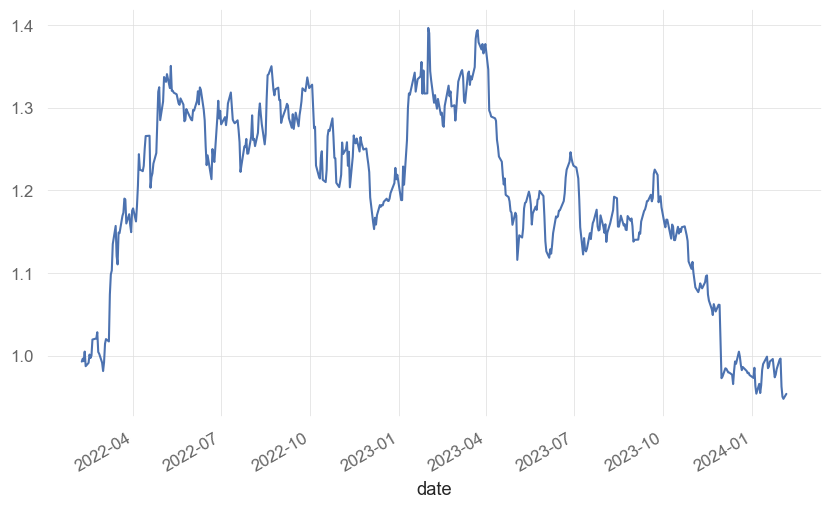

In [13]:
data.pair_ratio.plot()

## Execution

Compute the rolling z score of the ratio of VLO to PSX

In [14]:
data["z"] = (
  data.pair_ratio
  - data.pair_ratio.rolling(window=window).mean()
) / data.pair_ratio.rolling(window=window).std()

In [15]:
data

,psx,vlo,pair_ratio,z
date,,,,
2022-02-07,90.29,89.63,0.992690,NaN
2022-02-08,88.82,88.49,0.996285,NaN
2022-02-09,89.45,88.84,0.993181,NaN
2022-02-10,89.46,89.89,1.004807,NaN
2022-02-11,93.20,92.00,0.987124,NaN
...,...,...,...,...
2024-01-30,142.41,141.89,0.996349,1.251981
2024-01-31,144.31,138.90,0.962511,-1.209289
2024-02-01,145.55,138.29,0.950120,-1.847787


Now we create a long position (represented by 1) if the z-score falls below the lower threshold. We create a short position (represented by -1) if the z-score rises above the upper threshold. In other words, if the normalized difference between the spread and the refiner is at an extreme value, we expect it to revert back to its mean.

In [19]:
data["position"] = np.select(
    [data.z < -thresh, data.z > thresh],
    [1, -1],
    default=0
)

Calculate the returns on owning VLO

In [21]:
data["vlo_returns"] = data.vlo.apply(np.log).diff(1)

In [22]:
data

,psx,vlo,pair_ratio,z,position,vlo_returns
date,,,,,,
2022-02-07,90.29,89.63,0.992690,NaN,0,NaN
2022-02-08,88.82,88.49,0.996285,NaN,0,-0.012801
2022-02-09,89.45,88.84,0.993181,NaN,0,0.003947
2022-02-10,89.46,89.89,1.004807,NaN,0,0.011750
2022-02-11,93.20,92.00,0.987124,NaN,0,0.023202
...,...,...,...,...,...,...
2024-01-30,142.41,141.89,0.996349,1.251981,0,0.025049
2024-01-31,144.31,138.90,0.962511,-1.209289,0,-0.021298
2024-02-01,145.55,138.29,0.950120,-1.847787,1,-0.004401


To compute the strategy returns, we multiply the position value by the return. We shift the position data by one day, aligning yesterday's position with today's returns, and then multiply it with VLO's returns for the current period. If the position value is 1 (long) and the return is positive, we have a positive return for that day. If the position value is 1 (long) and the return is negative, we have a negative return for that day.

In [23]:
strategy_returns = data.position.shift(1) * data.vlo_returns

In [24]:
qs.reports.metrics(
    strategy_returns,
    mode="full"
)

                           Strategy
-------------------------  ----------
Start Period               2022-02-08
End Period                 2024-02-05
Risk-Free Rate             0.0%
Time in Market             26.0%

Cumulative Return          -29.58%
CAGR﹪                     -11.45%

Sharpe                     -0.74
Prob. Sharpe Ratio         15.02%
Smart Sharpe               -0.72
Sortino                    -1.0
Smart Sortino              -0.98
Sortino/√2                 -0.71
Smart Sortino/√2           -0.69
Omega                      0.79

Max Drawdown               -39.24%
Longest DD Days            692
Volatility (ann.)          20.96%
Calmar                     -0.29
Skew                       -0.03
Kurtosis                   12.93

Expected Daily %           -0.07%
Expected Monthly %         -1.39%
Expected Yearly %          -11.03%
Kelly Criterion            -11.81%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.23%
Expected Shortfall (cVaR)  -2.23%

Max Consecu